# SurFree: a fast surrogate-free black-box attack
论文：https://arxiv.org/abs/2011.12807v1  
代码：https://github.com/t-maho/SurFree  
参考某公众号文章：https://mp.weixin.qq.com/s/ooLe3TRWm_YjhzYfB4bYLg

![none](./算法推导1.jpg)

![jupyter](./算法推导2.jpg)

### 用mnist数据集训练一个简单的神经网络

In [1]:
from torchvision.datasets import mnist,CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=4,kernel_size=5,stride=1,padding=2)#1*28*28->4*28*28->4*14*14          
        self.conv2 = nn.Conv2d(4,8,5,padding=2)#4*14*14->8*14*14->8*7*7
        self.fc1 = nn.Linear(8*7*7,500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)  
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):#64*1*28*28
        x = F.relu(self.conv1(x))#64*4*28*28
        x = self.pool(x)#64*4*14*14
        x = F.relu(self.conv2(x))#64*8*14*14
        x = self.pool(x)#64*8*7*7
        #x = x.view(-1,8*7*7)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))#64*500
        x = self.dropout(x)#64*500
        x = self.fc2(x)#64*10
        x = F.softmax(x,dim=1)#64*10
        return x
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features,10)
    def forward(self,x):
        return self.model(x)
    
def save(model,path):
    if 'Cifar' in path:
        torch.save(model.model.state_dict(), path)
    else:
        torch.save(model.state_dict(), path)

def load(model,path):
    if 'Cifar' in path:
        model = model.model
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [3]:
def load_setup(dataset):
    train_batch_size = 64
    test_batch_size = 64
    if dataset == 'mnist':
        transform = transforms.ToTensor()
        trainSet = mnist.MNIST('./data', train=True, transform=transform, download=True)
        testSet = mnist.MNIST('./data', train=False, transform=transform)
        trainLoader = DataLoader(trainSet, batch_size=train_batch_size, shuffle=True)
        testLoader = DataLoader(testSet, batch_size=test_batch_size, shuffle=False)
        classes = ('0','1','2','3','4','5','6','7','8','9')
        model = CNN()
        path = 'CNNforMnist'
    elif dataset == 'cifar10':
        tf = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
        trainSet = CIFAR10(root='./data', train=True,download=True, transform=tf)
        testSet = CIFAR10(root='./data', train=False,download=True, transform=tf)
        trainLoader = DataLoader(trainSet, batch_size=train_batch_size,shuffle=True)
        testLoader = DataLoader(testSet, batch_size=test_batch_size,shuffle=False)
        classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        model = ResNet()
        path = 'resnet18forCifar10'
    return trainSet,trainLoader,testLoader,classes,model,path

In [4]:
dataset = 'mnist'
#dataset = 'cifar10'
trainSet,trainLoader,testLoader,classes,model,path = load_setup(dataset)

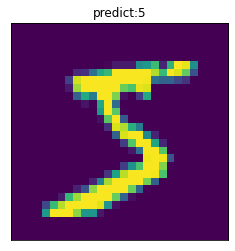

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show(img):
    npimg  = img.clone().detach().numpy()
    shape = npimg.shape
    #npimg = (npimg.reshape(shape[0],-1) * np.array(std).reshape(-1,1)+np.array(mean).reshape(-1,1)).reshape(shape)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'predict:{classes[model(img.unsqueeze(0)).max(1)[1].item()]}')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

image,label = trainSet[0]
show(image)

In [7]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
def train(model,trainLoader,testLoader):
    print('----train start----')
    epoch = 5
    device = torch.device("cuda:0")
    model.to(device)
    loss_func = CrossEntropyLoss()
    optimizer = Adam(model.parameters())
    
    trainAccuracy = 0
    testAccuracy = 0

    for i in range(epoch):
        model.train()
        for image, label in trainLoader:
            image=image.to(device)
            label = label.to(device)
            out = model(image)
            loss = loss_func(out, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predict = out.max(1)[1]
            trainAccuracy += (predict == label).sum().item()

        trainAccuracy/=len(trainLoader.dataset)

        with torch.no_grad():
            model.eval()
            for image, label in testLoader:
                image=image.to(device)
                label = label.to(device)
                out = model(image)

                predict = out.max(1)[1]
                testAccuracy += (predict == label).sum().item()

            testAccuracy/=len(testLoader.dataset)

        print(f'epoch:{i}  Train Accuracy:{trainAccuracy*100:.1f}%  Test Accuracy:{testAccuracy*100:.1f}%')
    print('----train finish----')
    return model.to('cpu')

In [323]:
model = train(model,trainLoader,testLoader)
save(model,path)

----train start----
epoch:0  Train Accuracy:96.4%  Test Accuracy:88.4%
epoch:1  Train Accuracy:97.4%  Test Accuracy:90.5%
epoch:2  Train Accuracy:97.9%  Test Accuracy:89.5%
epoch:3  Train Accuracy:98.1%  Test Accuracy:89.7%
epoch:4  Train Accuracy:98.4%  Test Accuracy:89.4%
----train finish----


In [6]:
model = load(model,path)

# 开始进行对抗攻击

## 找一个预测正确的图片作为原始图片 根据其生成对抗样本

In [7]:
def is_adversarial(shape,xo,x,model):
    xo = xo.reshape(1,*shape)
    x = x.reshape(1,*shape)
    return model(xo).max(1)[1].item() != model(x).max(1)[1].item()

In [8]:
def l2_norm_distance(x1,x2):
    d = np.linalg.norm(x1-x2,axis=1)
    return np.linalg.norm(d)

真实:7


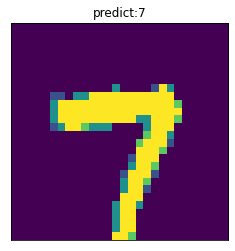

In [20]:
index = torch.randint(0,len(trainSet),(1,)).item()
xo = trainSet[index][0]
shape = xo.shape
y_true = trainSet[index][1]
pre = model(xo.unsqueeze(0)).max(1)[1].item()
show(xo)
print(f'真实:{classes[y_true]}')

## 随机生成一个噪声或其他图片(分类与原始图片不同)

1


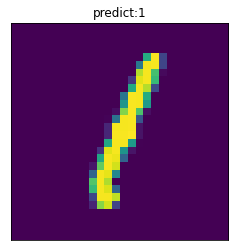

In [21]:
while True:
    index = torch.randint(0,len(trainSet),(1,)).item()
    y_adv = trainSet[index][1]
    if y_adv !=y_true:
        break
y0 = trainSet[index][0]
show(y0)
print(classes[y_adv])

## 将xo与y0组合为对抗样本 二分搜索找到分类正确与错误的边界(失真最小)

In [22]:
threshold = 1e-4
low = 0
high = 1
query = 0
d_list = []
flag = False
while high-low>threshold or not flag:
    mid = (low+high)/2
    y = mid*xo + (1-mid)*y0
    query += 1
    d_list.append(l2_norm_distance(y,xo))
    if is_adversarial(shape,xo,y,model):
        low = mid
        flag = True
    else:
        high = mid
        flag = False

0.38946533203125


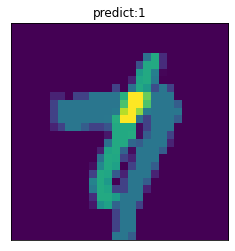

In [23]:
r = mid
print(r)
xb = r*xo + (1-r)*y0
show(xb)

## 由于角度未知 论文采用一个个尝试的办法 从设定的最大值逐渐减小 接着二分查找找到边界

In [24]:
theta_max = 30
l = 10#二分搜索次数
T = 3
k = 0.02#找不到theta时 减小theta_max
L = 100
tao = torch.zeros(2*T)
for i in range(2*T):
    if i%2:
        tao[i] = -(T-(i-1)/2)/T
    else:
        tao[i] = (T-i/2)/T
tao

tensor([ 1.0000, -1.0000,  0.6667, -0.6667,  0.3333, -0.3333])

## 初始化
根据二分搜索找到的第一个边界对抗样本xb及原始图片xo生成单位向量u1  
利用施密特正交化方法 根据随机向量t1生成一个与u1正交的随机单位向量v1  

In [25]:
shape = xo.shape
xo = xo.flatten(1)
xb = xb.flatten(1)
channel = xo.shape[0]
D = xo.shape[1]
x = xb

## 此论文中的施密特正交化 
前k-1个向量:v1 v2 ... vk-1 已经正交化 不需要变  
uk得到uk_  
tk得到vk  
满足vk随机生成，且与v1 v2 ... vk-1 uk 正交 从而与u1正交  
需满足向量的个数小于维度数  

In [26]:
def inner_dot(x,y):
    dot = x*y
    dot = dot.sum(1).reshape(-1,1)
    return dot
def schmidt(V,uk,tk):
    #V是之前生成的标准正交基
    uk_ = uk.clone()
    vk = tk.clone()
    for vi in V:
        uk_ -= vi*inner_dot(uk,vi)
        vk -= vi*inner_dot(tk,vi)
    uk_ /= np.linalg.norm(uk_,axis=1).reshape(-1,1)
    vk -= uk_*inner_dot(tk,uk_)
    vk /= np.linalg.norm(vk,axis=1).reshape(-1,1)
    return vk

In [27]:
V = []
query_limit = 6000
d_decrease = []
for epoch in range(D-1):
    if query > query_limit:
        break
    d = np.linalg.norm(x-xo,axis=1).reshape(-1,1)
    d = torch.Tensor(d)
    d_decrease.append(l2_norm_distance(x,xo))
    u = (x-xo)/d
    success = False
    
    if epoch%10==0:
        print(f'{epoch=},d={l2_norm_distance(x,xo):.2f}')
    
    while not success:
        t = torch.Tensor(np.random.normal(0, 1, (channel,D)))
        t = t/np.linalg.norm(t,axis=1).reshape(-1,1)
        #根据u生成v
        v = schmidt(V,u,t)
        V.append(v)
        if len(V)>L:
            V = V[1:]
        #根据u v 生成x
        index = 0
        while index < 2*T:
            t = tao[index]
            index += 1
            theta = theta_max * t * np.pi / 180
            n = np.cos(theta)*u + np.sin(theta)*v
            x_ = (d * np.cos(theta)*n+xo).clip(0,1) # 这个公式保证了d是单调减的
            query += 1
            d_list.append(l2_norm_distance(x_,xo))
            if is_adversarial(shape,xo,x_,model):
                success = True
                x = x_
                break
        #二分搜索找边界
        if success:
            t = tao[index-1]
            low = t
            high = t + np.sign(t)
            step = 0
            flag = False
            while step < l or not flag:
                step += 1
                mid = (low+high)/2
                theta = theta_max * mid * np.pi / 180
                n = np.cos(theta)*u + np.sin(theta)*v
                x = (d * np.cos(theta)*n+xo).clip(0,1)#clip的范围必须和预处理时归一化的范围一致
                query += 1
                d_list.append(l2_norm_distance(x_,xo))
                if is_adversarial(shape,xo,x,model):
                    low = mid
                    flag = True
                else:
                    high = mid
                    flag = False
            theta_max /= 1-k
        else:
            theta_max *= 1-k
            V.pop()
x = x.reshape(shape)

epoch=0,d=6.94
epoch=10,d=5.99
epoch=20,d=5.54
epoch=30,d=5.40
epoch=40,d=5.09
epoch=50,d=4.99
epoch=60,d=4.85
epoch=70,d=4.72
epoch=80,d=4.63
epoch=90,d=4.54
epoch=100,d=4.44
epoch=110,d=4.36
epoch=120,d=4.06
epoch=130,d=3.89
epoch=140,d=3.76
epoch=150,d=3.62
epoch=160,d=3.45
epoch=170,d=3.34
epoch=180,d=3.18
epoch=190,d=3.07
epoch=200,d=2.96
epoch=210,d=2.89
epoch=220,d=2.78
epoch=230,d=2.69
epoch=240,d=2.61
epoch=250,d=2.49


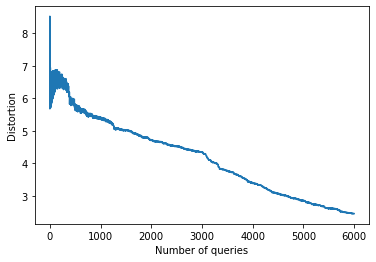

In [28]:
plt.xlabel('Number of queries')
plt.ylabel('Distortion')
plt.plot(range(len(d_list)),d_list)
plt.show()

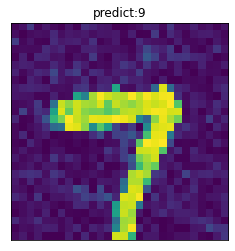

In [29]:
show(x)